In [1]:
import matplotlib.pyplot as plt
import numpy as np
import lensit as li
from scipy import stats

plt.rcParams['figure.figsize'] = [10, 5]

import os
if not 'LENSIT' in os.environ.keys():
    os.environ['LENSIT'] = '_tmp'
    
# 1906.08760
# https://github.com/carronj/plancklens
# https://github.com/JulienPeloton/lenscov
# https://github.com/JulienPeloton/lenscov/blob/master/src/loop_lensing.f90#L12


In [2]:
exp = 'SO'
LDres = 12
HDres = 14
nsims = 2

# Use this to get a maps
maps = li.get_maps_lib(exp, LDres, HDres=HDres, cache_lenalms=False, cache_maps=False, nsims=nsims, same_phi=True)

In [3]:
0.74*2**14

12124.16

In [4]:
# iso here means isotropic - not sure what this instance represents yet... but will use this for quadratic estimation
isocov = li.get_isocov(exp, LDres, HDres)

In [5]:
# Returns inverse of array whilst avoiding 0s
def inverse_nonzero(array):
    ret = np.zeros_like(array)
    ret[np.where(array > 0)] = 1./array[np.where(array > 0)]
    return ret

# Returns weiner filtered data 
def wiener_filter(lib_qlm, alm, Cl_true, N):
    '''
    C_true/(C_true + N) * alm
    '''
    return lib_qlm.almxfl(alm, Cl_true * inverse_nonzero(Cl_true + N))

# Easier to read grabbing of CAMB power spectra
def get_camb_Cl(lensed = True, key='pp'):
    if lensed:
        return li.get_fidcls()[1][key]
    else:
        return li.get_fidcls()[0][key]


# Quadratic estimator of phi from T
def get_phi_QE_T(Tmap, lib_qlm):
    estimator = 'T'
    T_alm = isocov.lib_datalm.map2alm(Tmap)
    
    # Don't know what this is but it's needed for calculation of phi. The index [1] = 0
    iblm = isocov.get_iblms(estimator, np.atleast_2d(T_alm), use_cls_len=True)[0]
    
    phi_lm_QE = 0.5 * isocov.get_qlms(estimator, iblm, lib_qlm, use_cls_len=True)[0]     # The index [1] gives QE Omega instead
    N0 = isocov.get_N0cls(estimator, lib_qlm)[0]      # The index [1] would give the equivalent for Omega
    
    # Normalise with this or with response???????????????
    #phi_lm_QE = lib_qlm.almxfl(phi_lm_QE, N0)
    
    # What is the response?????????????????????  [1] is the OO and [2] is the pO
    #response = isocov.get_response(estimator, lib_qlm)[0]      
    #norm = inverse_nonzero(response)
    #phi_lm_QE = lib_qlm.almxfl(phi_lm_QE, norm)
    
    phi = lib_qlm.almxfl(phi_lm_QE, N0)
    
    return phi, N0

def get_omega_QE_T(Tmap, lib_qlm, cls="lensed"):
    estimator = 'T'
    T_alm = isocov.lib_datalm.map2alm(Tmap)
    
    use_cls_len = True if cls == "lensed" else False
    # Don't know what this is but it's needed for calculation of phi. The index [1] = 0
    iblm = isocov.get_iblms(estimator, np.atleast_2d(T_alm), use_cls_len=use_cls_len)[0]
    
    omega_lm_QE = 0.5 * isocov.get_qlms(estimator, iblm, lib_qlm, use_cls_len=use_cls_len)[1]     # The index [1] gives QE Omega instead
    N0 = isocov.get_N0cls(estimator, lib_qlm)[1]      # The index [1] would give the equivalent for Omega
    

    omega_lm_QE = lib_qlm.almxfl(omega_lm_QE, N0)
    
    return omega_lm_QE, N0

def get_omega_QE_TQU(Tmap, Qmap, Umap, lib_qlm, cls="lensed"):
    estimator = 'TQU'
    T_alm = isocov.lib_datalm.map2alm(Tmap)
    Q_alm = isocov.lib_datalm.map2alm(Qmap)
    U_alm = isocov.lib_datalm.map2alm(Umap)
    
    
    use_cls_len = True if cls == "lensed" else False
    
    # Don't know what this is but it's needed for calculation of phi. The index [1] = 0
    iblm = isocov.get_iblms(estimator, np.array([T_alm, Q_alm, U_alm]), use_cls_len=True)[0]
    
    omega_lm_QE = 0.5 * isocov.get_qlms(estimator, iblm, lib_qlm, use_cls_len=True)[1]     # The index [1] gives QE Omega instead
    N0 = isocov.get_N0cls(estimator, lib_qlm)[1]      # The index [1] would give the equivalent for Omega
    
    omega = lib_qlm.almxfl(omega_lm_QE, N0)
    
    return omega, N0

def get_phi_QE_QU(Qmap, Umap, lib_qlm):
    estimator = 'QU'
    Q_alm = isocov.lib_datalm.map2alm(Qmap)
    U_alm = isocov.lib_datalm.map2alm(Umap)
    
    # Don't know what this is but it's needed for calculation of phi. The index [1] = 0
    iblm = isocov.get_iblms(estimator, np.array([Q_alm, U_alm]), use_cls_len=True)[0]
    phi_lm_QE = 0.5 * isocov.get_qlms(estimator, iblm, lib_qlm, use_cls_len=True)[0]     # The index [1] gives QE Omega instead
    N0 = isocov.get_N0cls(estimator, lib_qlm)[0]      # The index [1] would give the equivalent for Omega
    
    return phi_lm_QE, N0

def get_phi_QE_TQU(Tmap, Qmap, Umap, lib_qlm):
    estimator = 'TQU'
    T_alm = isocov.lib_datalm.map2alm(Tmap)
    Q_alm = isocov.lib_datalm.map2alm(Qmap)
    U_alm = isocov.lib_datalm.map2alm(Umap)
    
    # Don't know what this is but it's needed for calculation of phi. The index [1] = 0
    iblm = isocov.get_iblms(estimator, np.array([T_alm, Q_alm, U_alm]), use_cls_len=True)[0]
    
    phi_lm_QE = 0.5 * isocov.get_qlms(estimator, iblm, lib_qlm, use_cls_len=True)[0]     # The index [1] gives QE Omega instead
    N0 = isocov.get_N0cls(estimator, lib_qlm)[0]      # The index [1] would give the equivalent for Omega
    
    phi = lib_qlm.almxfl(phi_lm_QE, N0)
    
    return phi, N0

In [6]:
def get_ps(lib, alm, ellmax, alm2=None, N0=None):
    """
    calculates power spectrum
    
    lib is instance of ffs_covs.ell_mat.ffs_alm_pyFFTW
    alm can be extracted from instances of sims.ffs_cmbs.sims_cmb_len.(unlcmbs).get_sim_<desired_alm>(<index>)
    return ell and ps for values of ell where ps > 0
    """
    if alm2 is not None:
        # Convert alm and alm2 into Cl (cross power spectrum)
        Cl = lib.alm2cl(alm, alm2)
    else:
        # Convert alm into Cl (power spectrum)
        Cl = lib.alm2cl(alm)
        
    #if N0 is not None:
        #assert np.shape(Cl) == np.shape(N0)
        #Cl = Cl - N0
            
            
    # For some reason, some Cl values are 0 (this due to no. of pixels?), this extracts the index at which Cl is not 0
    Cl = Cl[:ellmax + 1]
    if N0 is not None:
        N0 = N0[:ellmax + 1]
        ell1 = np.where(Cl > 0.)[0]
        print(ell1[:10])
        ell2 = np.where(N0 > 0.)[0]
        print(ell2[:10])
        ell = np.intersect1d(ell1, ell2)
        ps = 1e7 * (Cl - N0)[ell]*(ell*(ell+1))**2/(2*np.pi)
    else:
        ell = np.where(Cl != 0.)[0] # indices at which ps is not 0, ell=indices
        # Calculating Cl*(l*(l+1))^2/(2*pi)
        ps = 1e7 * Cl[ell]*(ell*(ell+1))**2/(2*np.pi)
        
    return ell, ps


def get_camb_ps(ellmax):
    ell_camb = np.arange(ellmax + 1)
    camb_Cl_phi = get_camb_Cl(lensed=False, key='pp')
    camb_ps = 1e7 * camb_Cl_phi[ell_camb] * (ell_camb**2) * ((ell_camb+1)**2)/(2*np.pi)
    return camb_ps, ell_camb
    
def get_binned_ps(lib, alm, Nbins, ellmax, alm2=None, N0=None):
    """
    calculates power spectrum and bins it
    
    lib is instance of ffs_covs.ell_mat.ffs_alm_pyFFTW
    alm and alm2 can be extracted from instances of sims.ffs_cmbs.sims_cmb_len.(unlcmbs).get_sim_<desired_alm>(<index>)
    returns binned ell and ps for values of ell where ps > 0
    """
    ell, ps = get_ps(lib, alm, ellmax, alm2, N0)
    # Take the means of binned ps for cleaner plot
    means, bin_edges, binnumber = stats.binned_statistic(ell, ps, 'mean', bins=Nbins)
    counts, *others = stats.binned_statistic(ell, ps, 'count', bins=Nbins)
    stds, *others = stats.binned_statistic(ell, ps, 'std', bins=Nbins)
    errors = stds/np.sqrt(counts)
    binSeperation = bin_edges[1]
    ellBins = np.asarray([bin_edges[i] - binSeperation/2 for i in range(1, len(bin_edges))])
    
    return ellBins, np.abs(means), errors

def get_binned_N0(lib, N0, Nbins, ellmax):
    
    N0 = N0[:ellmax + 1]
    ell = np.where(N0 > 0.)[0]
    N0 = 1e7 * N0[ell]*(ell*(ell+1))**2/(2*np.pi)
    
    N0_mean, bin_edges, binnumber = stats.binned_statistic(ell, N0, 'mean', bins=Nbins)
    counts, *others = stats.binned_statistic(ell, N0, 'count', bins=Nbins)
    stds, *others = stats.binned_statistic(ell, N0, 'std', bins=Nbins)
    errors = stds/np.sqrt(counts)
    binSeperation = bin_edges[1]
    ellBins = np.asarray([bin_edges[i] - binSeperation/2 for i in range(1, len(bin_edges))])
    return ellBins, N0_mean, errors
    

def plot_QE_ps(ell, ps, error, title, camb=True, log=True, ylabel=None, N0=None, Nerr=None):
    """
    Plots power spectrum. If camb=True, fiducial ps also plotted for given field.
    """
    plt.figure()
    plt.errorbar(ell, ps, yerr=error, label=("QE"))
    plt.title(title)
    plt.xlabel("$L$", fontsize=14)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=14)
    else:
        plt.ylabel("$L^2(L + 1)^2 C^{\hat \phi - \phi_{in}}_L/2\pi$", fontsize=14)
    
    if camb:
        ellmax = int(np.max(ell) + 1)
        camb_ps, ell_camb = get_camb_ps(ellmax)
        plt.plot(ell_camb, camb_ps, label="CAMB")
    if log:
        plt.semilogy()
        
    if N0 is not None:
        plt.errorbar(ell, N0, yerr=Nerr, label=("N0"))
        
    plt.legend()
    

In [7]:
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Qmap0,Umap0  = maps.get_sim_qumap(0)

Tmap1 = maps.get_sim_tmap(1)
Qmap1, Umap1 = maps.get_sim_qumap(1)

Same phi realisation for all maps
Same phi realisation for all maps
Same phi realisation for all maps
Same phi realisation for all maps


In [8]:
phi_0, N0_0 = get_phi_QE_TQU(Tmap0,Qmap0, Umap0, lib_qlm)

phi_1, N0_1 = get_phi_QE_TQU(Tmap1,Qmap1, Umap1, lib_qlm)

ellmax = 3000
Nbins = 50

     [00:00:11]  (total [00:00:11])   get_qlms::mult with len Pmat  
     [00:01:23]  (total [00:01:35])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:01:38])   get_qlms::rotation to phi Omega  
     [00:00:12]  (total [00:00:12])   get_qlms::mult with len Pmat  
     [00:01:25]  (total [00:01:37])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:01:39])   get_qlms::rotation to phi Omega  


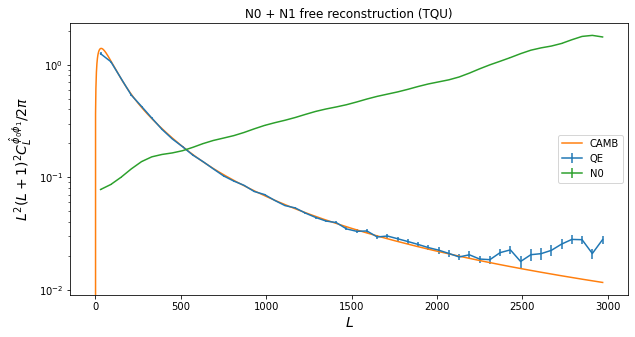

In [11]:
# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_1, Nbins, ellmax,alm2=phi_0)
ell_N0_binned, N0_binned, N0_err = get_binned_N0(lib_qlm, N0_0, Nbins, ellmax)
plot_QE_ps(ell_binned, cross_ps_binned, err, title="N0 + N1 free reconstruction (TQU)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$", N0=N0_binned, Nerr=N0_err)


In [12]:
omega_0, N0_0 = get_omega_QE_TQU(Tmap0,Qmap0, Umap0, lib_qlm)

omega_1, N0_1 = get_omega_QE_TQU(Tmap1,Qmap1, Umap1, lib_qlm)

ellmax = 3000
Nbins = 50

     [00:00:12]  (total [00:00:12])   get_qlms::mult with len Pmat  
     [00:01:23]  (total [00:01:36])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:01:38])   get_qlms::rotation to phi Omega  
     [00:00:11]  (total [00:00:11])   get_qlms::mult with len Pmat  
     [00:01:24]  (total [00:01:36])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:01:38])   get_qlms::rotation to phi Omega  


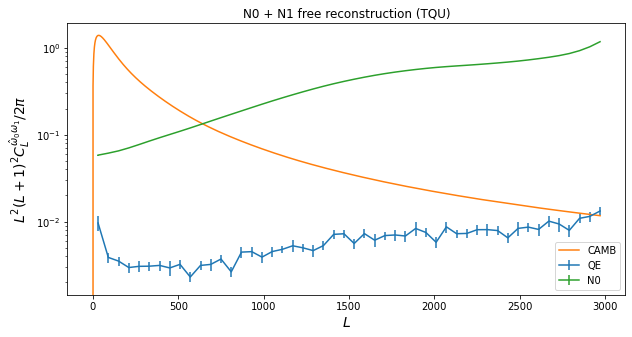

In [13]:
# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, omega_1, Nbins, ellmax,alm2=omega_0)
ell_N0_binned, N0_binned, N0_err = get_binned_N0(lib_qlm, N0_0, Nbins, ellmax)
plot_QE_ps(ell_binned, cross_ps_binned, err, title="N0 + N1 free reconstruction (TQU)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \omega_0 \omega_1}_L/2\pi$", N0=N0_binned, Nerr=N0_err)


In [7]:
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

omega_0, N0_0 = get_omega_QE_T(Tmap0, maps.lib_skyalm)

omega_1, N0_1 = get_omega_QE_T(Tmap1, maps.lib_skyalm)

ellmax = 3000
Nbins = 50



Same phi realisation for all maps
Same phi realisation for all maps
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:01]  (total [00:00:01])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:04])   get_qlms::rotation to phi Omega  


AssertionError: 

In [ ]:
# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(maps.lib_skyalm, omega_0, Nbins, ellmax, alm2=omega_1)
ell_N0_binned, N0_binned, N0_err = get_binned_N0(lib_qlm, N0_0, Nbins, ellmax)
plot_QE_ps(ell_binned, cross_ps_binned, err, title="N0 + N1 free reconstruction (TQU)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \omega_0 \omega_1}_L/2\pi$", N0=N0_binned, Nerr=N0_err)


     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:30]  (total [00:00:30])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:32])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:30]  (total [00:00:30])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:32])   get_qlms::rotation to phi Omega  


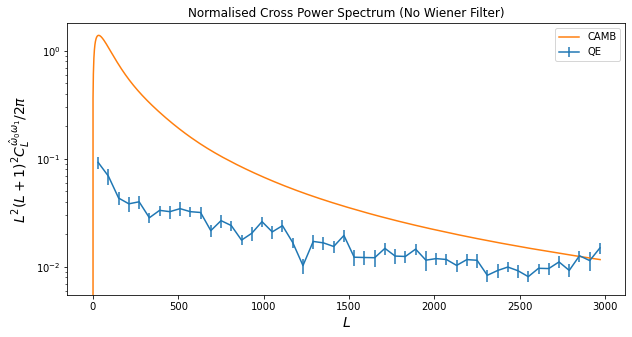

In [6]:
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

omega_0, N0_0 = get_omega_QE_T(Tmap0, lib_qlm)

omega_1, N0_1 = get_omega_QE_T(Tmap1, lib_qlm)

ellmax = 3000
Nbins = 50

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, omega_0, Nbins, ellmax, alm2=omega_1)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Normalised Cross Power Spectrum (No Wiener Filter)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \omega_0 \omega_1}_L/2\pi$")


Using same phi realisation for all maps (I think)
Using same phi realisation for all maps (I think)
     _get_pmati:: cached _tmp/temp/Covs/SO/LD12HD12/T_Pmatinv_len_00.npy
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:01]  (total [00:00:01])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:01])   get_qlms::rotation to phi Omega  
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   inverse len Pmats  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxx , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:01])   Fyy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:02])   Fxy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:02])   Fxx , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:03])   Fyy , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:03])   Fxy , part 2  curvpOlm 
     [00:00:04] 

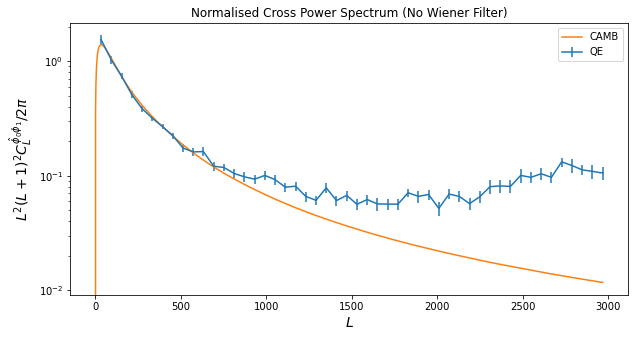

In [39]:
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

phi_0, N0_0 = get_phi_QE_T(Tmap0, lib_qlm)


phi_1, N0_1 = get_phi_QE_T(Tmap1, lib_qlm)


ellmax = 3000
Nbins = 50

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax, alm2=phi_1)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Normalised Cross Power Spectrum (No Wiener Filter)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$")


Same phi realisation for all maps
Same phi realisation for all maps
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:04]  (total [00:00:04])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:05])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:04]  (total [00:00:04])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:05])   get_qlms::rotation to phi Omega  


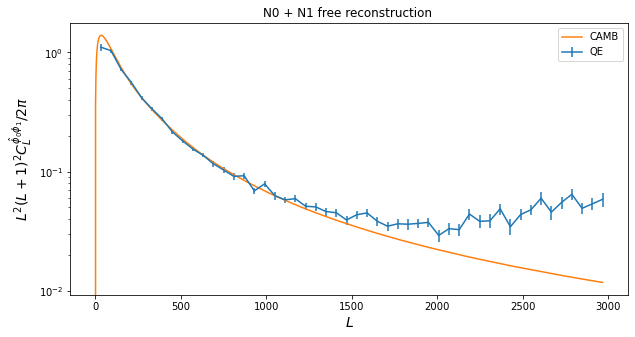

In [14]:
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

phi_0, N0_0 = get_phi_QE_T(Tmap0, lib_qlm)

phi_1, N0_1 = get_phi_QE_T(Tmap1, lib_qlm)

ellmax = 3000
Nbins = 50

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax, alm2=phi_1)
plot_QE_ps(ell_binned, cross_ps_binned, err, "N0 + N1 free reconstruction ", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$")


Using same phi realisation for all maps (I think)
Using same phi realisation for all maps (I think)
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:05]  (total [00:00:05])   get_qlms::cartesian gradients  
     [00:00:01]  (total [00:00:06])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:05]  (total [00:00:05])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:06])   get_qlms::rotation to phi Omega  


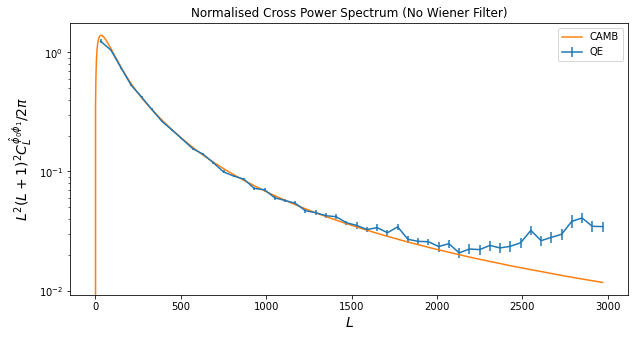

In [8]:
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

phi_0, N0_0 = get_phi_QE_T(Tmap0, lib_qlm)
phi_0 = lib_qlm.almxfl(phi_0, N0_0)

phi_1, N0_1 = get_phi_QE_T(Tmap1, lib_qlm)
phi_1 = lib_qlm.almxfl(phi_1, N0_1)

ellmax = 3000
Nbins = 50

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax, alm2=phi_1)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Normalised Cross Power Spectrum (No Wiener Filter)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$")


     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:31]  (total [00:00:31])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:33])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:29]  (total [00:00:29])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:32])   get_qlms::rotation to phi Omega  


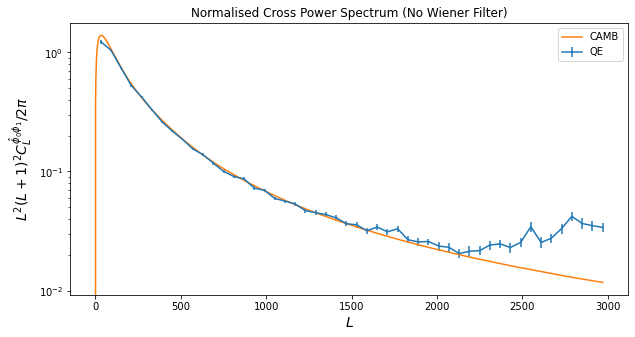

In [7]:
# HD=14, LD=14, S4
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

phi_0, N0_0 = get_phi_QE_T(Tmap0, lib_qlm)
phi_0 = lib_qlm.almxfl(phi_0, N0_0)

phi_1, N0_1 = get_phi_QE_T(Tmap1, lib_qlm)
phi_1 = lib_qlm.almxfl(phi_1, N0_1)

ellmax = 3000
Nbins = 50

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax, alm2=phi_1)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Normalised Cross Power Spectrum (No Wiener Filter)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$")


     _get_pmati:: cached _tmp/temp/Covs/S6/LD14HD14/T_Pmatinv_len_00.npy
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:35]  (total [00:00:35])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:38])   get_qlms::rotation to phi Omega  
  lensit.ffs_covs.ffs_cov   [00:00:01]  (total [00:00:01])   inverse len Pmats  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:18]  (total [00:00:19])   Fxx , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:19]  (total [00:00:38])   Fyy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:18]  (total [00:00:57])   Fxy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:19]  (total [00:01:16])   Fxx , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:18]  (total [00:01:35])   Fyy , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:17]  (total [00:01:53])   Fxy , part 2  curvpOlm 
     [00:02:05]  (total [00:02:05])   get_qlm_resplm:: get curvature matrices  
     [00:00:02]  (total [00:02:08]) 

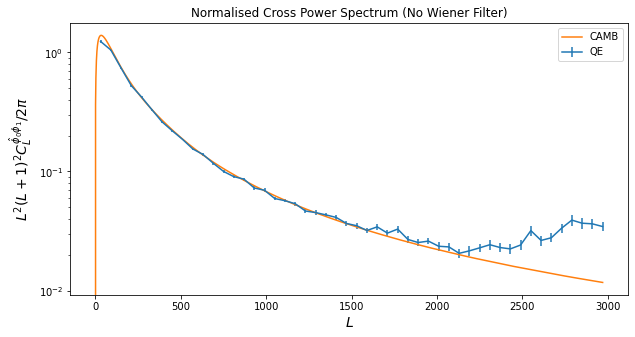

In [14]:
# HD=14, LD=14, S6
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

phi_0, N0_0 = get_phi_QE_T(Tmap0, lib_qlm)
phi_0 = lib_qlm.almxfl(phi_0, N0_0)

phi_1, N0_1 = get_phi_QE_T(Tmap1, lib_qlm)
phi_1 = lib_qlm.almxfl(phi_1, N0_1)

ellmax = 3000
Nbins = 50

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax, alm2=phi_1)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Normalised Cross Power Spectrum (No Wiener Filter)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$")


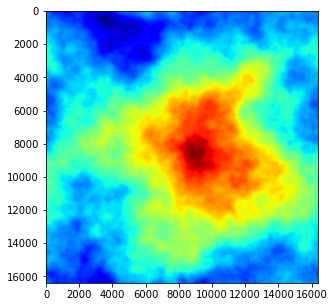

In [17]:
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1./cl[np.where(cl > 0)]
    return ret
# get the analytic N0 reconstruction noise
# fiducial lensing power spectrum
cpp = li.get_fidcls()[0]['pp'][:lib_qlm.ellmax+1]
# multiply a_lm by Wiener filter
lib_qlm.almxfl(phi_0, cpp*cli(N0_0 + cpp), inplace=True)
lensmap = lib_qlm.alm2map(phi_0)
plt.imshow(lensmap, cmap='jet')

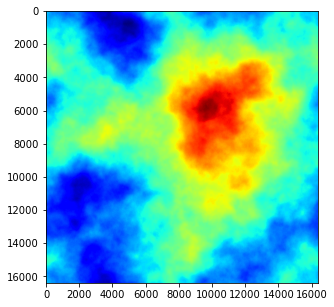

In [23]:
lib_qlm.udgrade(maps.lencmbs.lib_skyalm, maps.lencmbs.get_sim_plm(0))
lensmap = lib_qlm.alm2map(phi_lm_inp)
plt.imshow(lensmap, cmap='jet')

Same phi realisation for all maps
Same phi realisation for all maps
     _get_pmati:: cached _tmp/temp/Covs/SO/LD14HD11/T_Pmatinv_len_00.npy
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:30]  (total [00:00:30])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:32])   get_qlms::rotation to phi Omega  
  lensit.ffs_covs.ffs_cov   [00:00:01]  (total [00:00:01])   inverse len Pmats  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:17]  (total [00:00:18])   Fxx , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:17]  (total [00:00:36])   Fyy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:17]  (total [00:00:53])   Fxy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:17]  (total [00:01:11])   Fxx , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:16]  (total [00:01:27])   Fyy , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:17]  (total [00:01:44])   Fxy , part 2  curvpOlm 
     [00:01:56]  (total [00:01:56])   get_qlm_re

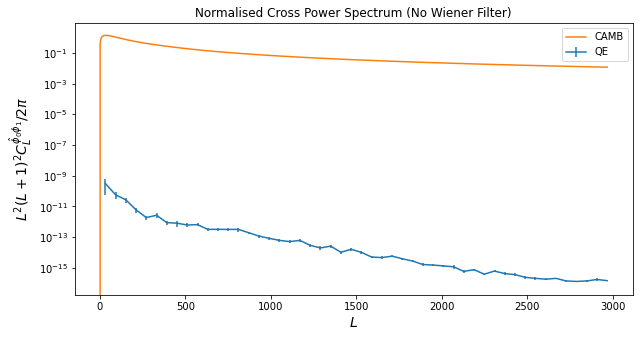

In [25]:
# Hdres=11
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

phi_0, N0_0 = get_phi_QE_T(Tmap0, lib_qlm)
phi_0 = lib_qlm.almxfl(phi_0, N0_0)

phi_1, N0_1 = get_phi_QE_T(Tmap1, lib_qlm)
phi_1 = lib_qlm.almxfl(phi_1, N0_1)

ellmax = 3000
Nbins = 50

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax, alm2=phi_1)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Normalised Cross Power Spectrum (No Wiener Filter)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$")


Same phi realisation for all maps
Same phi realisation for all maps
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:30]  (total [00:00:30])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:32])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:30]  (total [00:00:30])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:32])   get_qlms::rotation to phi Omega  


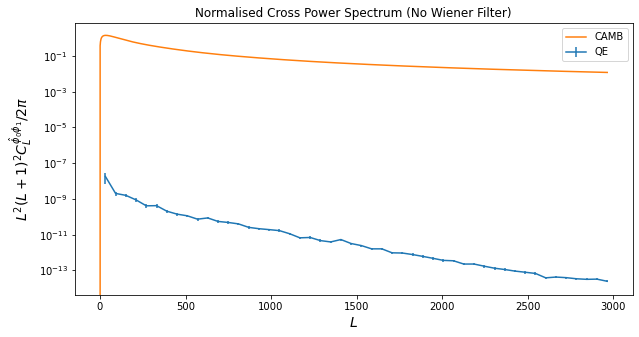

In [19]:
# Hdres=12
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

phi_0, N0_0 = get_phi_QE_T(Tmap0, lib_qlm)
phi_0 = lib_qlm.almxfl(phi_0, N0_0)

phi_1, N0_1 = get_phi_QE_T(Tmap1, lib_qlm)
phi_1 = lib_qlm.almxfl(phi_1, N0_1)

ellmax = 3000
Nbins = 50

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax, alm2=phi_1)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Normalised Cross Power Spectrum (No Wiener Filter)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$")


Same phi realisation for all maps
Same phi realisation for all maps
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:32]  (total [00:00:32])   get_qlms::cartesian gradients  
     [00:00:01]  (total [00:00:34])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:29]  (total [00:00:29])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:31])   get_qlms::rotation to phi Omega  


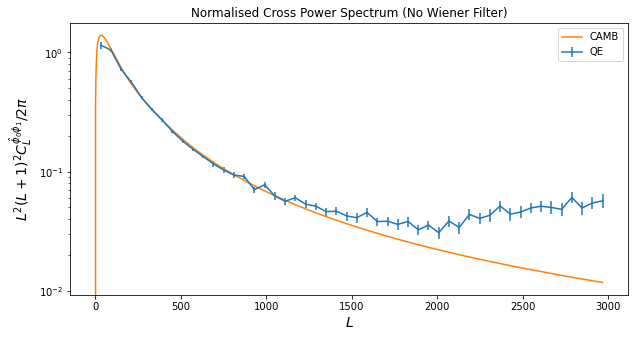

In [13]:
# Hdres=13
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

phi_0, N0_0 = get_phi_QE_T(Tmap0, lib_qlm)
phi_0 = lib_qlm.almxfl(phi_0, N0_0)

phi_1, N0_1 = get_phi_QE_T(Tmap1, lib_qlm)
phi_1 = lib_qlm.almxfl(phi_1, N0_1)

ellmax = 3000
Nbins = 50

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax, alm2=phi_1)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Normalised Cross Power Spectrum (No Wiener Filter)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$")


Same phi realisation for all maps
Same phi realisation for all maps
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:04]  (total [00:00:04])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:05])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:04]  (total [00:00:04])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:05])   get_qlms::rotation to phi Omega  


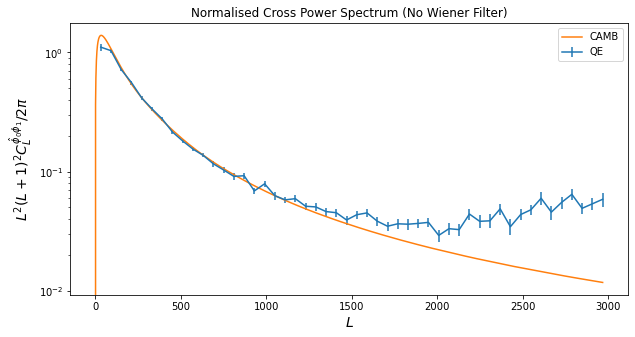

In [31]:
# Hdres=13
# LDres=13
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

phi_0, N0_0 = get_phi_QE_T(Tmap0, lib_qlm)
phi_0 = lib_qlm.almxfl(phi_0, N0_0)

phi_1, N0_1 = get_phi_QE_T(Tmap1, lib_qlm)
phi_1 = lib_qlm.almxfl(phi_1, N0_1)

ellmax = 3000
Nbins = 50

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax, alm2=phi_1)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Normalised Cross Power Spectrum (No Wiener Filter)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$")


Same phi realisation for all maps
Same phi realisation for all maps
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  


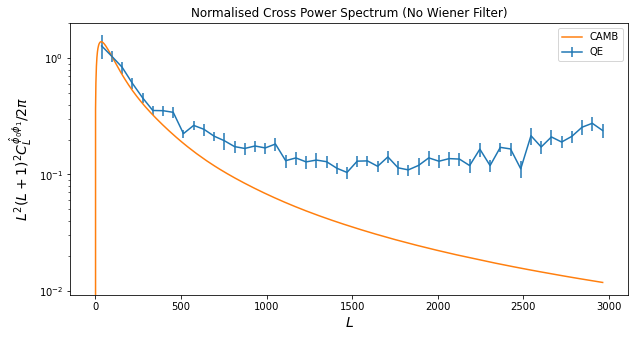

In [37]:
# Hdres=11
# LDres=11
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

phi_0, N0_0 = get_phi_QE_T(Tmap0, lib_qlm)
phi_0 = lib_qlm.almxfl(phi_0, N0_0)

phi_1, N0_1 = get_phi_QE_T(Tmap1, lib_qlm)
phi_1 = lib_qlm.almxfl(phi_1, N0_1)

ellmax = 3000
Nbins = 50

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax, alm2=phi_1)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Normalised Cross Power Spectrum (No Wiener Filter)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$")


In [44]:
lib_qlm = isocov.lib_skyalm

Tmap_0 = maps.get_sim_tmap(0)


omega_0, N0_0 = get_omega_QE_T(Tmap_0, lib_qlm)

ellmax = 3000
Nbins = 50

     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:05]  (total [00:00:05])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:06])   get_qlms::rotation to phi Omega  


[ 1  2  3  5  6  7  8  9 10 11]
[ 1  2  3  5  6  7  8  9 10 11]
tt
ee
bb
te
pp
pt
pe
tt
ee
bb
te
pp
pt
pe


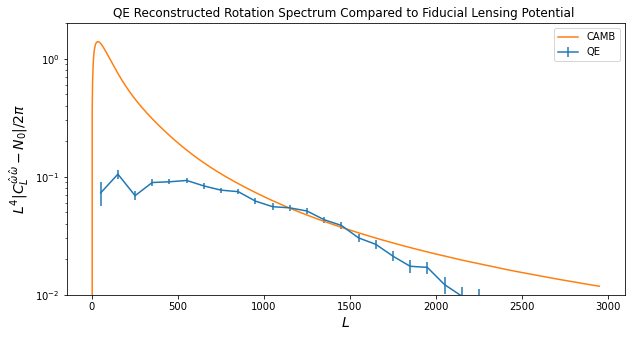

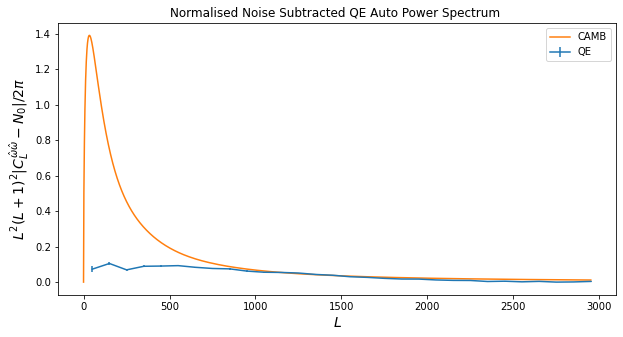

In [45]:
Nbins=30
ell_binned, auto_ps_binned, err = get_binned_ps(lib_qlm, omega_0, Nbins, ellmax, N0=N0_0)
plot_QE_ps(ell_binned, auto_ps_binned, err, "QE Reconstructed Rotation Spectrum Compared to Fiducial Lensing Potential ", log=True, camb=True, ylabel="$L^4 |C^{\hat \omega \hat \omega}_L - N_0|/2\pi$")
plt.ylim(1e-2,2)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Normalised Noise Subtracted QE Auto Power Spectrum ", log=False, camb=True, ylabel="$L^2(L + 1)^2 |C^{\hat \omega \hat \omega}_L - N_0|/2\pi$")

In [7]:
# lib_qlm = isocov.lib_skyalm

# Tmap0 = maps.get_sim_tmap(0)
T_alm_unl_0 = maps.lencmbs.unlcmbs.get_sim_tlm(0)
tmap_tmp = maps.lib_skyalm.almxfl(T_alm_unl_0, maps.cl_transf)
tmap_tmp = maps.lib_datalm.alm2map(maps.lib_datalm.udgrade(maps.lencmbs.unlcmbs.lib_skyalm, tmap_tmp))
# Tmap_unl_0 = tmap_tmp + maps.get_noise_sim_tmap(0)
Tmap_unl_0 = tmap_tmp

omega_0, N0_0 = get_omega_QE_T(Tmap_unl_0, maps.lencmbs.unlcmbs.lib_skyalm, cls="unlensed")

ellmax = 3000
Nbins = 50


     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:31]  (total [00:00:31])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:34])   get_qlms::rotation to phi Omega  


[ 1  2  3  5  6  7  8  9 10 11]
[ 1  2  3  5  6  7  8  9 10 11]


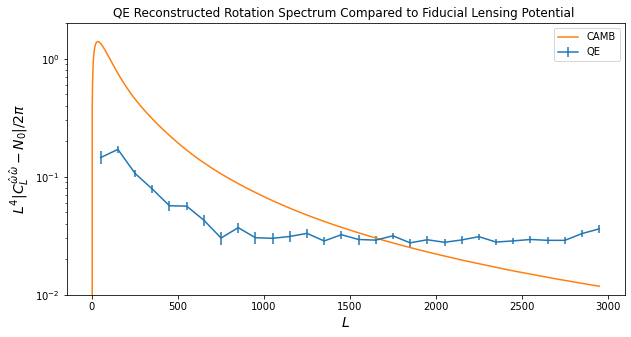

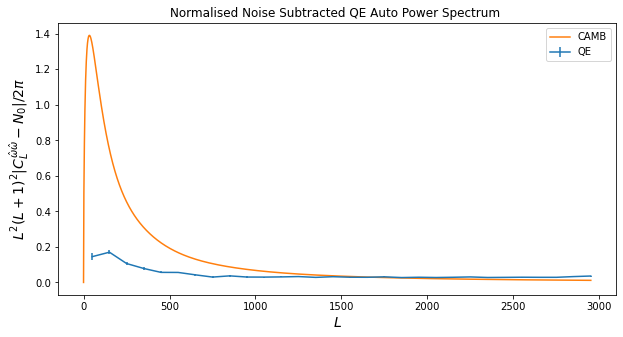

In [9]:
Nbins=30
ell_binned, auto_ps_binned, err = get_binned_ps(maps.lencmbs.unlcmbs.lib_skyalm, omega_0, Nbins, ellmax, N0=N0_0)
plot_QE_ps(ell_binned, auto_ps_binned, err, "QE Reconstructed Rotation Spectrum Compared to Fiducial Lensing Potential ", log=True, camb=True, ylabel="$L^4 |C^{\hat \omega \hat \omega}_L - N_0|/2\pi$")
plt.ylim(1e-2,2)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Normalised Noise Subtracted QE Auto Power Spectrum ", log=False, camb=True, ylabel="$L^2(L + 1)^2 |C^{\hat \omega \hat \omega}_L - N_0|/2\pi$")

In [16]:
# lib_qlm = isocov.lib_skyalm

# Tmap0 = maps.get_sim_tmap(0)
T_alm_unl_0 = maps.lencmbs.unlcmbs.get_sim_tlm(0)
tmap_tmp = maps.lib_skyalm.almxfl(T_alm_unl_0, maps.cl_transf)
tmap_tmp = maps.lib_datalm.alm2map(maps.lib_datalm.udgrade(maps.lencmbs.unlcmbs.lib_skyalm, tmap_tmp))
Tmap_unl_0 = tmap_tmp + maps.get_noise_sim_tmap(0)

omega_0, N0_0 = get_omega_QE_T(Tmap_unl_0, maps.lencmbs.unlcmbs.lib_skyalm, cls="unlensed")

T_alm_unl_1 = maps.lencmbs.unlcmbs.get_sim_tlm(1)
tmap_tmp = maps.lib_skyalm.almxfl(T_alm_unl_1, maps.cl_transf)
tmap_tmp = maps.lib_datalm.alm2map(maps.lib_datalm.udgrade(maps.lencmbs.unlcmbs.lib_skyalm, tmap_tmp))
Tmap_unl_1 = tmap_tmp + maps.get_noise_sim_tmap(1)

omega_1, N0_1 = get_omega_QE_T(Tmap_unl_1, maps.lencmbs.unlcmbs.lib_skyalm, cls="unlensed")

ellmax = 3000
Nbins = 50


     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:32]  (total [00:00:32])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:34])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:32]  (total [00:00:32])   get_qlms::cartesian gradients  
     [00:00:02]  (total [00:00:34])   get_qlms::rotation to phi Omega  


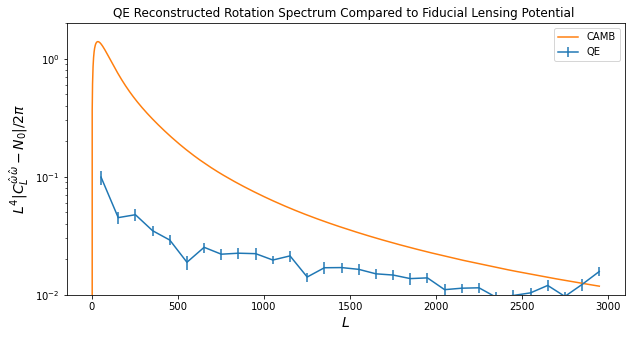

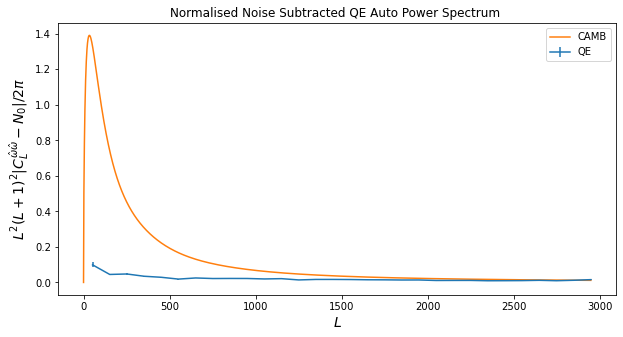

In [17]:
Nbins=30
ell_binned, auto_ps_binned, err = get_binned_ps(maps.lencmbs.unlcmbs.lib_skyalm, omega_0, Nbins, ellmax, alm2=omega_1)
plot_QE_ps(ell_binned, auto_ps_binned, err, "QE Reconstructed Rotation Spectrum Compared to Fiducial Lensing Potential ", log=True, camb=True, ylabel="$L^4 |C^{\hat \omega \hat \omega}_L - N_0|/2\pi$")
plt.ylim(1e-2,2)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Normalised Noise Subtracted QE Auto Power Spectrum ", log=False, camb=True, ylabel="$L^2(L + 1)^2 |C^{\hat \omega \hat \omega}_L - N_0|/2\pi$")

In [14]:

T_alm_unl_0 = maps.lencmbs.unlcmbs.get_sim_tlm(0)
tmap_tmp = maps.lib_skyalm.almxfl(T_alm_unl_0, maps.cl_transf)
tmap_tmp = maps.lib_datalm.alm2map(maps.lib_datalm.udgrade(maps.lencmbs.unlcmbs.lib_skyalm, tmap_tmp))
Tmap_unl_0 = tmap_tmp + maps.get_noise_sim_tmap(0)

T_alm_unl_1 = maps.lencmbs.unlcmbs.get_sim_tlm(1)
tmap_tmp = maps.lib_skyalm.almxfl(T_alm_unl_1, maps.cl_transf)
tmap_tmp = maps.lib_datalm.alm2map(maps.lib_datalm.udgrade(maps.lencmbs.unlcmbs.lib_skyalm, tmap_tmp))
Tmap_unl_1 = tmap_tmp + maps.get_noise_sim_tmap(1)

omega_0, N0_0 = get_omega_QE_T(Tmap_unl_0, maps.lencmbs.unlcmbs.lib_skyalm)
omega_1, N0_1 = get_omega_QE_T(Tmap_unl_1, maps.lencmbs.unlcmbs.lib_skyalm)


ellmax = 3000
Nbins = 50

Nbins=30


     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:06]  (total [00:00:06])   get_qlms::cartesian gradients  
     [00:00:04]  (total [00:00:10])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:05]  (total [00:00:05])   get_qlms::cartesian gradients  
     [00:00:04]  (total [00:00:10])   get_qlms::rotation to phi Omega  


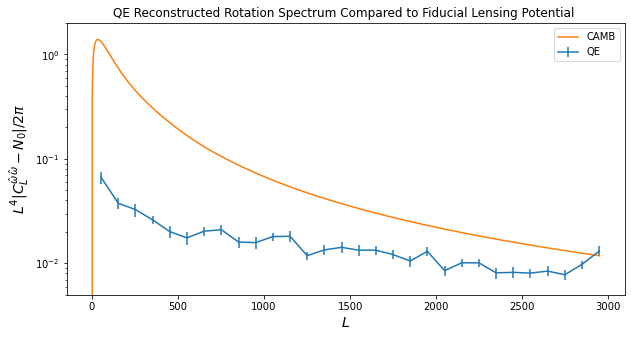

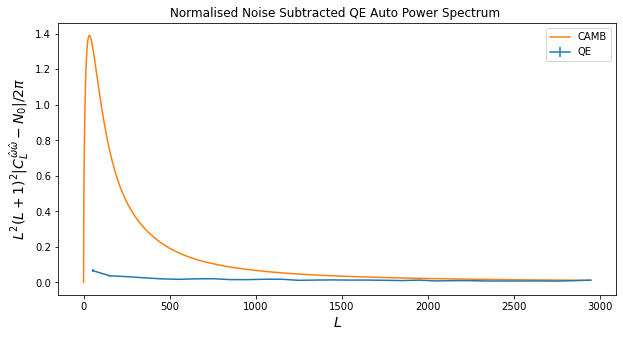

In [15]:
ell_binned, auto_ps_binned, err = get_binned_ps(lib_qlm, omega_0, Nbins, ellmax, alm2=omega_1)
plot_QE_ps(ell_binned, auto_ps_binned, err, "QE Reconstructed Rotation Spectrum Compared to Fiducial Lensing Potential ", log=True, camb=True, ylabel="$L^4 |C^{\hat \omega \hat \omega}_L - N_0|/2\pi$")
plt.ylim(5e-3,2)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Normalised Noise Subtracted QE Auto Power Spectrum ", log=False, camb=True, ylabel="$L^2(L + 1)^2 |C^{\hat \omega \hat \omega}_L - N_0|/2\pi$")


     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:05]  (total [00:00:05])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:06])   get_qlms::rotation to phi Omega  
[ 1  2  3  5  6  7  8  9 10 11]
[ 1  2  3  5  6  7  8  9 10 11]


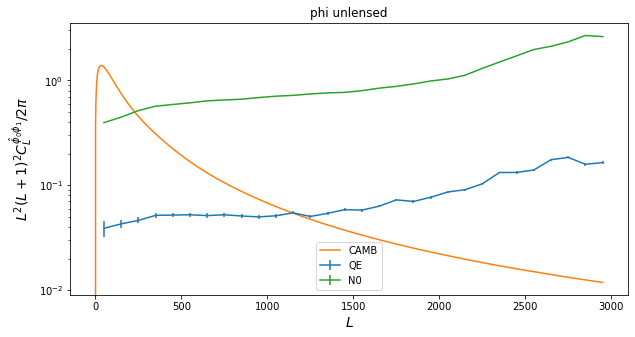

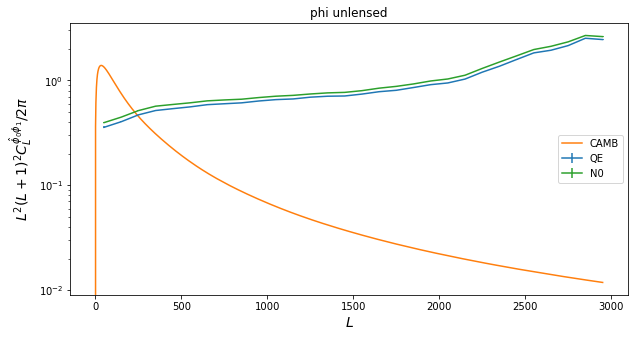

In [16]:
phi_0, N0_0 = get_phi_QE_T(Tmap_unl_0, lib_qlm)
phi_0 = lib_qlm.almxfl(phi_0, N0_0)
# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax, N0=N0_0)
ell_N0_binned, N0_binned, N0_err = get_binned_N0(lib_qlm, N0_0, Nbins, ellmax)
plot_QE_ps(ell_binned, cross_ps_binned, err, title="phi unlensed",camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$", N0=N0_binned, Nerr=N0_err)
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax)
plot_QE_ps(ell_binned, cross_ps_binned, err, title="phi unlensed",camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$", N0=N0_binned, Nerr=N0_err)



     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:05]  (total [00:00:05])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:06])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:05]  (total [00:00:05])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:06])   get_qlms::rotation to phi Omega  
tt
ee
bb
te
pp
pt
pe


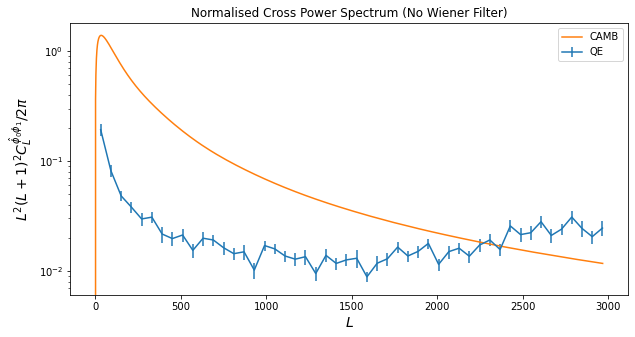

In [21]:
lib_qlm = isocov.lib_skyalm

Tmap0 = maps.get_sim_tmap(0)
Tmap1 = maps.get_sim_tmap(1)

phi_0, N0_0 = get_phi_QE_T(Tmap0, lib_qlm)
phi_0 = lib_qlm.almxfl(phi_0, N0_0)

phi_1, N0_1 = get_phi_QE_T(Tmap1, lib_qlm)
phi_1 = lib_qlm.almxfl(phi_1, N0_1)

phi_inp = maps.lencmbs.get_sim_plm(0)

ellmax = 3000
Nbins = 50

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_0, Nbins, ellmax, alm2=phi_1)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Normalised Cross Power Spectrum (No Wiener Filter)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi_0 \phi_1}_L/2\pi$")


In [ ]:
#--------------------------------

     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:05]  (total [00:00:05])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:06])   get_qlms::rotation to phi Omega  
tt
ee
bb
te
pp
pt
pe


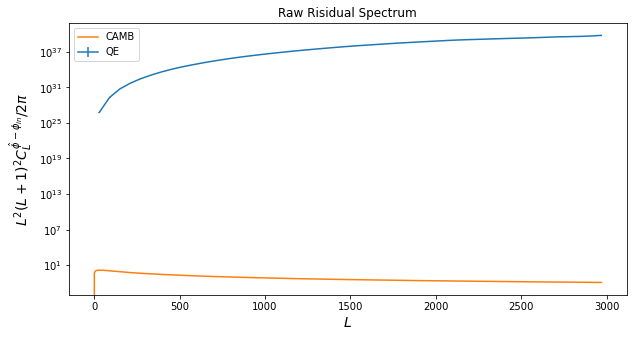

In [12]:
lib_qlm = isocov.lib_skyalm

Tmap = maps.get_sim_tmap(0)
phi_lm_QE_T, N0 = get_phi_QE_T(Tmap, lib_qlm)
phi_lm_inp = maps.lencmbs.get_sim_plm(0)
delta_phi_lm = phi_lm_QE_T - phi_lm_inp

ellmax = 3000
Nbins = 50
ell_binned, delta_ps_binned, err = get_binned_ps(lib_qlm, delta_phi_lm, Nbins, ellmax)

plot_QE_ps(ell_binned, delta_ps_binned, err, "Raw Risidual Spectrum", camb=True)

tt
ee
bb
te
pp
pt
pe


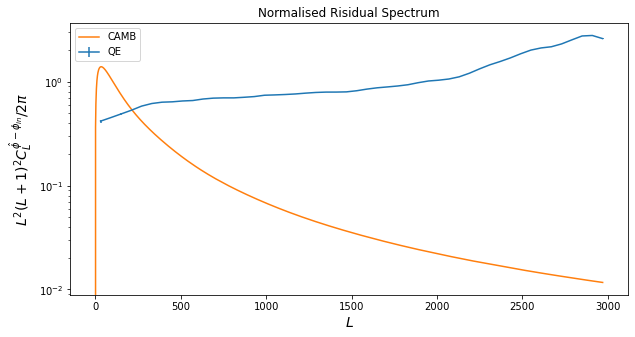

In [13]:
# Normalising QE
phi_lm_QE_T = lib_qlm.almxfl(phi_lm_QE_T, N0)

delta_phi_lm = phi_lm_QE_T - phi_lm_inp
ell_binned, delta_ps_binned, err = get_binned_ps(lib_qlm, delta_phi_lm, Nbins, ellmax)
plot_QE_ps(ell_binned, delta_ps_binned, err, "Normalised Risidual Spectrum", camb=True)

tt
ee
bb
te
pp
pt
pe
tt
ee
bb
te
pp
pt
pe


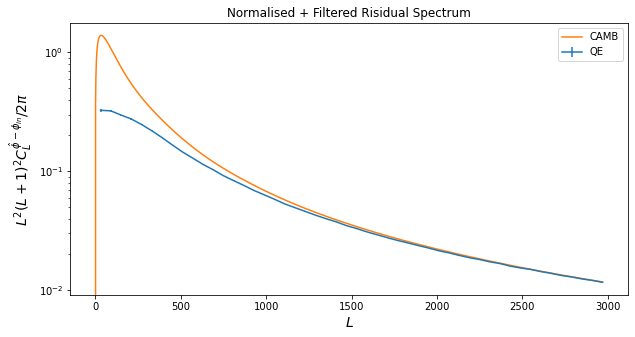

In [14]:
# Applying wiener filter to QE

# The 'true' power spectrum required for Weiner filter
Cl_phi_camb = get_camb_Cl(lensed=False, key='pp')[:lib_qlm.ellmax + 1]

# Applying Wiener filter to QE phi 
phi_lm_QE_T_wiener = wiener_filter(lib_qlm, phi_lm_QE_T, Cl_phi_camb, N0)

delta_phi_lm = phi_lm_QE_T_wiener - phi_lm_inp
ell_binned, delta_ps_binned, err = get_binned_ps(lib_qlm, delta_phi_lm, Nbins, ellmax)
plot_QE_ps(ell_binned, delta_ps_binned, err, "Normalised + Filtered Risidual Spectrum", camb=True)

tt
ee
bb
te
pp
pt
pe


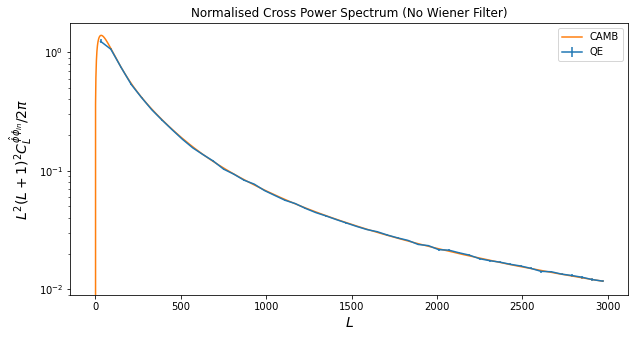

In [15]:
# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_lm_QE_T, Nbins, ellmax, alm2=phi_lm_inp)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Normalised Cross Power Spectrum (No Wiener Filter)", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi \phi_{in}}_L/2\pi$")

tt
ee
bb
te
pp
pt
pe
tt
ee
bb
te
pp
pt
pe
[ 1  2  3  5  6  7  8  9 10 11]
[ 1  2  3  5  6  7  8  9 10 11]
tt
ee
bb
te
pp
pt
pe
tt
ee
bb
te
pp
pt
pe


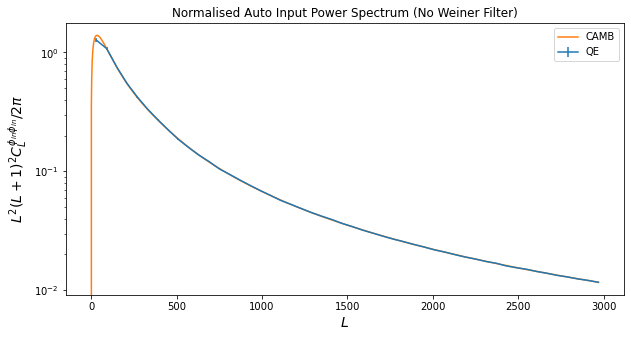

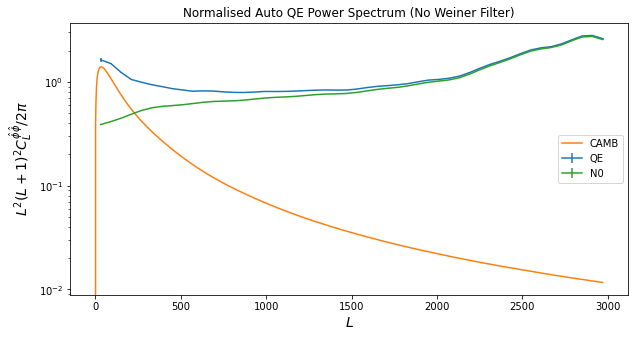

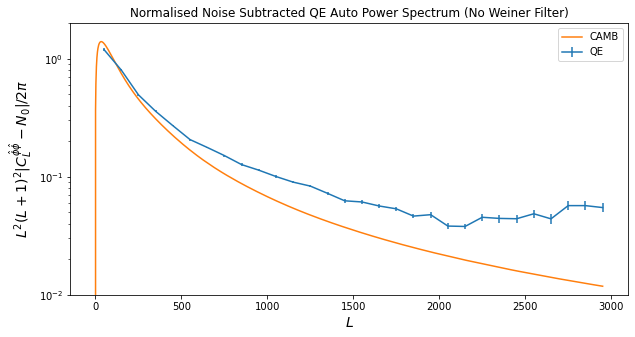

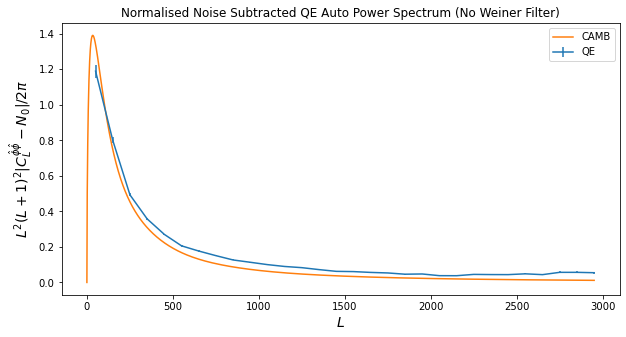

In [16]:
# Auto power spectrum
ell_binned, auto_ps_binned, err = get_binned_ps(lib_qlm, phi_lm_inp, Nbins, ellmax)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Normalised Auto Input Power Spectrum (No Weiner Filter)", log=True, camb=True, ylabel="$L^2(L + 1)^2 C^{\phi_{in} \phi_{in}}_L/2\pi$")

ell_binned, auto_ps_binned, err = get_binned_ps(lib_qlm, phi_lm_QE_T, Nbins, ellmax) 
ell_N0_binned, N0_binned, N0_err = get_binned_N0(lib_qlm, N0, Nbins, ellmax)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Normalised Auto QE Power Spectrum (No Weiner Filter)", log=True, camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi \hat \phi}_L/2\pi$", N0=N0_binned, Nerr=N0_err)

Nbins=30
ell_binned, auto_ps_binned, err = get_binned_ps(lib_qlm, phi_lm_QE_T, Nbins, ellmax, N0=N0)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Normalised Noise Subtracted QE Auto Power Spectrum (No Weiner Filter)", log=True, camb=True, ylabel="$L^2(L + 1)^2 |C^{\hat \phi \hat \phi}_L - N_0|/2\pi$")
plt.ylim(1e-2,2)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Normalised Noise Subtracted QE Auto Power Spectrum (No Weiner Filter)", log=False, camb=True, ylabel="$L^2(L + 1)^2 |C^{\hat \phi \hat \phi}_L - N_0|/2\pi$")

()
     [00:00:01]  (total [00:00:01])   get_qlms::mult with len Pmat  
     [00:00:10]  (total [00:00:12])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:13])   get_qlms::rotation to phi Omega  
[ 1  2  3  5  6  7  8  9 10 11]
[ 1  2  3  5  6  7  8  9 10 11]


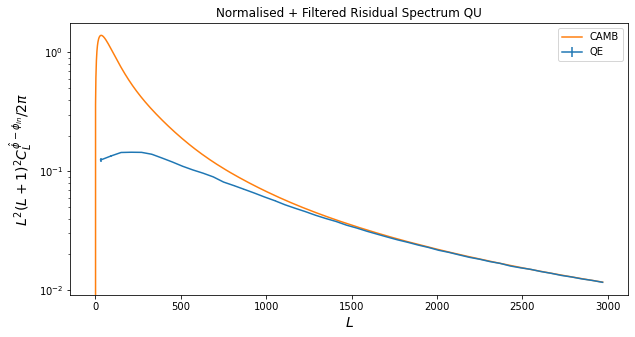

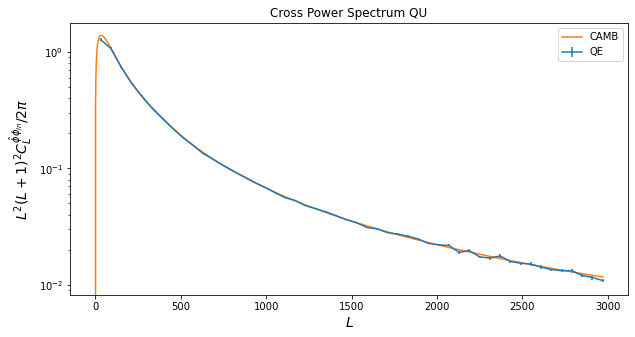

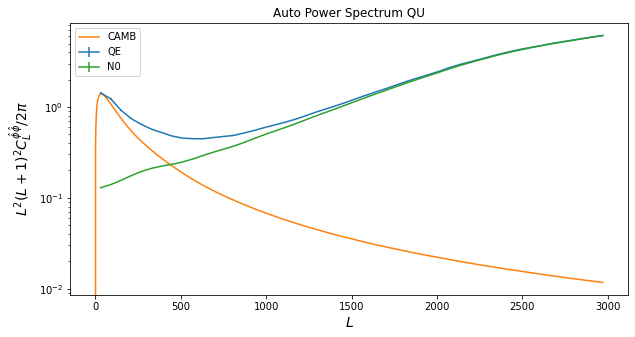

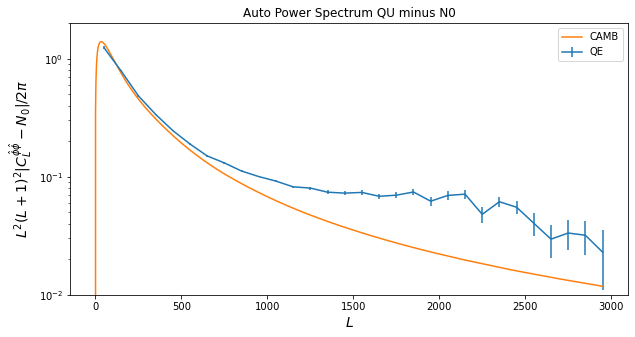

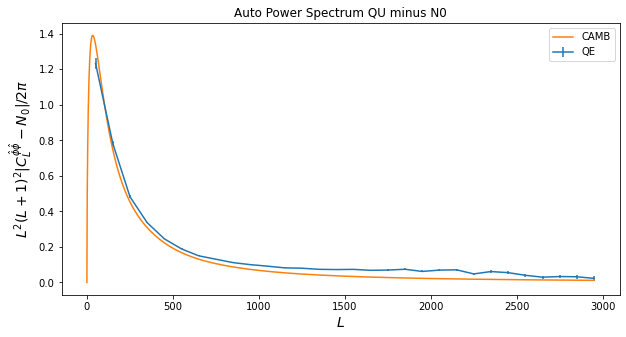

In [32]:
# QU estimator
Nbins=50

Qmap, Umap = maps.get_sim_qumap(0)
phi_lm_QE_QU, N0 = get_phi_QE_QU(Qmap, Umap, lib_qlm)
phi_lm_QE_QU = lib_qlm.almxfl(phi_lm_QE_QU, N0)
phi_lm_QE_QU_wiener = wiener_filter(lib_qlm, phi_lm_QE_QU, Cl_phi_camb, N0)

delta_phi_lm = phi_lm_QE_QU - phi_lm_inp
delta_phi_lm_wiener = phi_lm_QE_QU_wiener - phi_lm_inp

# Risidual spectrum
ell_binned, delta_ps_binned, err = get_binned_ps(lib_qlm, delta_phi_lm_wiener, Nbins, ellmax)
plot_QE_ps(ell_binned, delta_ps_binned, err, "Normalised + Filtered Risidual Spectrum QU", camb=True)

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_lm_QE_QU, Nbins, ellmax, alm2=phi_lm_inp)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Cross Power Spectrum QU", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi \phi_{in}}_L/2\pi$")

# Auto power spectrum
ell_binned, auto_ps_binned, err = get_binned_ps(lib_qlm, phi_lm_QE_QU, Nbins, ellmax)
ell_N0_binned, N0_binned, N0_err = get_binned_N0(lib_qlm, N0, Nbins, ellmax)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Auto Power Spectrum QU", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi \hat \phi}_L/2\pi$", N0=N0_binned, Nerr=N0_err)

# Auto minus N0
Nbins=30
ell_binned, auto_ps_binned, err = get_binned_ps(lib_qlm, phi_lm_QE_QU, Nbins, ellmax, N0=N0)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Auto Power Spectrum QU minus N0", camb=True, ylabel="$L^2(L + 1)^2 |C^{\hat \phi \hat \phi}_L - N_0|/2\pi$")
plt.ylim(1e-2,2)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Auto Power Spectrum QU minus N0", log=False, camb=True, ylabel="$L^2(L + 1)^2 |C^{\hat \phi \hat \phi}_L - N_0|/2\pi$")

()
     [00:00:03]  (total [00:00:03])   get_qlms::mult with len Pmat  
     [00:00:16]  (total [00:00:19])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:20])   get_qlms::rotation to phi Omega  
[ 1  2  3  5  6  7  8  9 10 11]
[ 1  2  3  5  6  7  8  9 10 11]


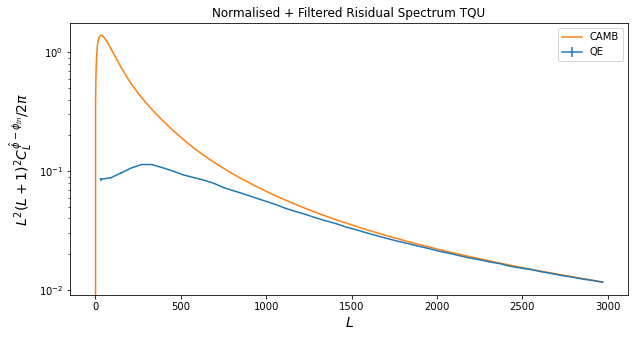

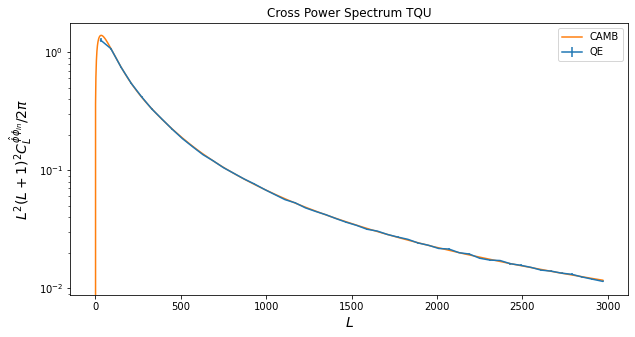

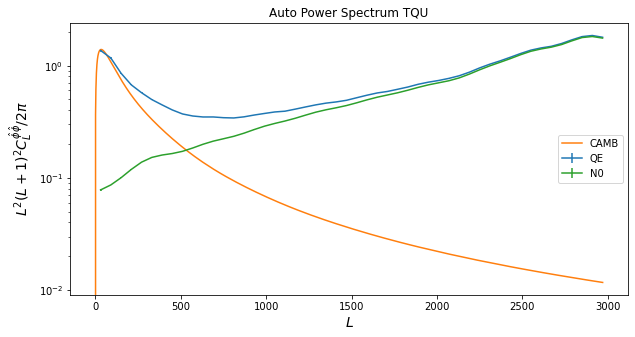

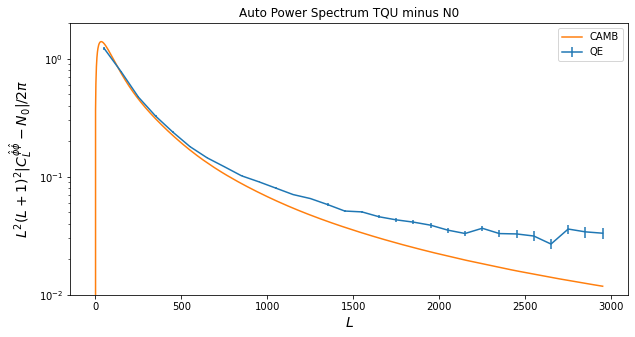

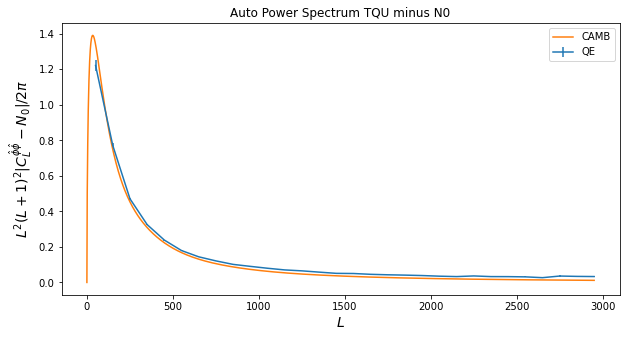

In [33]:
# TQU estimator
Nbins=50

phi_lm_QE_TQU, N0 = get_phi_QE_TQU(Tmap, Qmap, Umap, lib_qlm)
phi_lm_QE_TQU = lib_qlm.almxfl(phi_lm_QE_TQU, N0)
phi_lm_QE_TQU_wiener = wiener_filter(lib_qlm, phi_lm_QE_TQU, Cl_phi_camb, N0)

delta_phi_lm = phi_lm_QE_TQU - phi_lm_inp
delta_phi_lm_wiener = phi_lm_QE_TQU_wiener - phi_lm_inp

# Risidual spectrum
ell_binned, delta_ps_binned, err = get_binned_ps(lib_qlm, delta_phi_lm_wiener, Nbins, ellmax)
plot_QE_ps(ell_binned, delta_ps_binned, err, "Normalised + Filtered Risidual Spectrum TQU", camb=True)

# Cross power spectrum
ell_binned, cross_ps_binned, err = get_binned_ps(lib_qlm, phi_lm_QE_TQU, Nbins, ellmax, alm2=phi_lm_inp)
plot_QE_ps(ell_binned, cross_ps_binned, err, "Cross Power Spectrum TQU", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi \phi_{in}}_L/2\pi$")

# Auto power spectrum
ell_binned, auto_ps_binned, err = get_binned_ps(lib_qlm, phi_lm_QE_TQU, Nbins, ellmax)
ell_N0_binned, N0_binned, N0_err = get_binned_N0(lib_qlm, N0, Nbins, ellmax)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Auto Power Spectrum TQU", camb=True, ylabel="$L^2(L + 1)^2 C^{\hat \phi \hat \phi}_L/2\pi$", N0=N0_binned, Nerr=N0_err)

# Auto minus N0
Nbins=30
ell_binned, auto_ps_binned, err = get_binned_ps(lib_qlm, phi_lm_QE_TQU, Nbins, ellmax, N0=N0)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Auto Power Spectrum TQU minus N0", camb=True, ylabel="$L^2(L + 1)^2 |C^{\hat \phi \hat \phi}_L - N_0|/2\pi$")
plt.ylim(1e-2,2)
plot_QE_ps(ell_binned, auto_ps_binned, err, "Auto Power Spectrum TQU minus N0", log=False, camb=True, ylabel="$L^2(L + 1)^2 |C^{\hat \phi \hat \phi}_L - N_0|/2\pi$")